# Mask and Clip ICESat-2, and Difference from ASO

ICESat-2 is known to have higher accuracy over flat surfaces as opposed to rough surfaces and those with high slope. We aimed to select only ICESat-2 data points that occured in areas of slope < 20 degrees (ideally we would have chosen < 10 degrees, but a mask based on this threshold yielded almost no area within the watershed: even more ideally we would use slope of < 1 degree, as per the ATBD document https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL08_ATBD_r002_v2.pdf). We calculated slope using gdaldem with the ASO snow-off elevation data resampled to 9m resolution as the input. We clipped the ICESat-2 data to regions with this lower slope value, and then created a buffer around those points with a radius of 50m, since each ICESat-2 point represents a 100m sloping line along-track. We used zonal stats to compute the median elevation of the ASO data within each buffer, and then subtracted the ASO elevation from the ICESat-2 elevation.

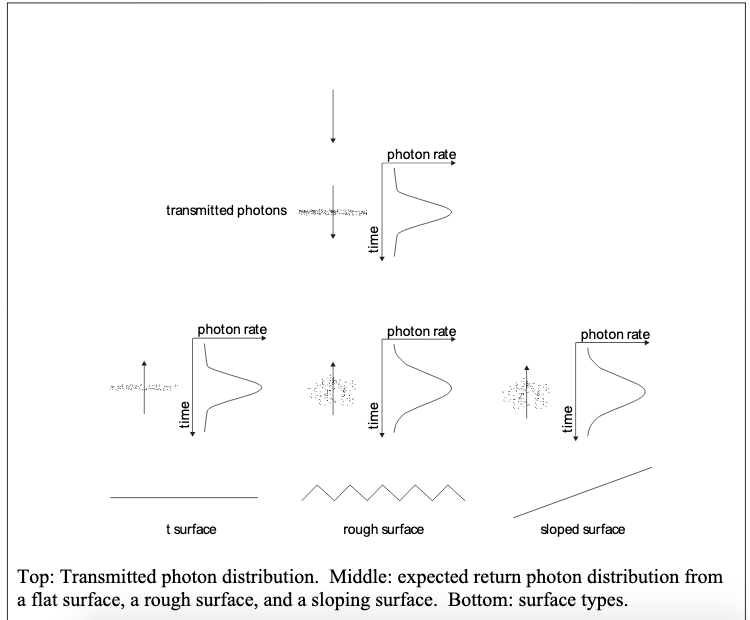

In [ ]:
#!pip install earthpy

In [2]:
#Open, Plot, and Explore Raster Data with Python 
#https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python/
#Applied to ASO Snow Off data from Tuolumne Meadows (downloaded from Linux Box Storage)

# Import necessary packages
import os
import rasterio
from rasterio.enums import Resampling
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns
from rasterstats import zonal_stats
import statistics
import scipy.stats as stats
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
import rioxarray as riox
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent
from rasterio import features

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

%matplotlib inline

In [3]:
#set working directory?
os.chdir(os.path.join(et.io.HOME, 
                      'ICESat-2_Snowdepth'))

In [4]:
#slope_fn = os.path.splitext(out_fn)[0]+'_gdaldem_slope_9m.tif'
#slope_fn

#!gdaldem slope $dtm_fn $slope_fn

In [5]:
fn = os.path.join("data",
                       "ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif")
# out_fn = os.path.join('data',
#                      'ASO_3m_dtm_USCATM__gdaldem_slope_9m_output.tif')
tuol_basin_fn = os.path.join('data',
                             'UpperTuolRiverBasin',
                            'UpperTuolRiverBasinOutline.shp')

## Mask Slopes Greater than 20 Degrees

In [6]:
# Code in this cell is from David Shean, supplied in March 2021

aso_feat_list = []
ovr_scale = 8
src = rio.open(fn)
a = src.read(1, masked=True, out_shape=(src.count, int(src.height / ovr_scale), int(src.width / ovr_scale)))
ovr_transform = src.transform * src.transform.scale(src.width / a.shape[-1], src.height / a.shape[-2])
b = ma.masked_where(a > 20, a)
mask = np.ma.getmaskarray(b).astype(np.uint8) - 1
shapes = features.shapes(mask, mask=mask, transform=ovr_transform)
geom_list = list(shapes)
dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-1]
aso_feat_list.extend([{'properties':{'fn':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list])
aso_gdf = gpd.GeoDataFrame.from_features(aso_feat_list, crs=src.crs)
#remove tiny polygons
area_thresh = 1e8
aso_gdf = aso_gdf.loc[aso_gdf.area > area_thresh]
#Shoud simplify and sieve

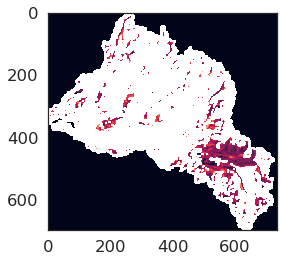

In [7]:
plt.imshow(b);

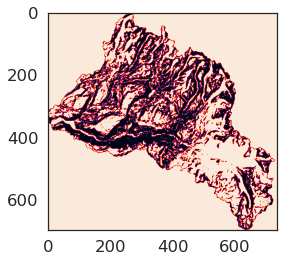

In [8]:
plt.imshow(mask);

In [9]:
aso_gdf

,geometry,fn,date
1079,"POLYGON ((254247.000 4229667.000, 254247.000 4...",data/ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif,9m
1722,"POLYGON ((273336.708 4229667.000, 273336.708 4...",data/ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif,9m


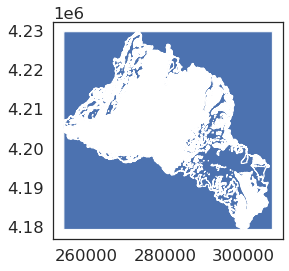

In [10]:
aso_gdf.plot();

In [11]:
tuol_basin = gpd.read_file(tuol_basin_fn)

# Change name of .csv that you read in
atlas_df = pd.read_csv('summer_2020_pre.csv')
atlas_gdf = gpd.GeoDataFrame(atlas_df, crs='epsg:32611', geometry=gpd.points_from_xy(atlas_df.x, atlas_df.y))

In [12]:
atlas_gdf.head()

,Unnamed: 0,Track,Unnamed: 0.1,h_te_mean,h_te_median,h_te_min,h_te_max,latitude,longitude,h_te_mode,h_te_skew,n_te_photons,segment_snowcover,terrain_slope,h_te_uncertainty,dem_h,x,y,geometry,date
0,0,gt3l,0,1986.278687,1986.257080,1985.621460,1986.947266,38.218727,-119.286774,1986.000000,0.122473,103.0,2.0,-0.009950,19.284258,1989.658081,299812.579385,4.232556e+06,POINT (299812.579 4232555.953),10/06/2020
1,1,gt3l,1,1984.924561,1984.889160,1984.154541,1986.050049,38.217827,-119.286880,1984.700073,0.815575,181.0,2.0,-0.011663,10.966432,1988.901611,299800.759407,4.232456e+06,POINT (299800.759 4232456.275),10/06/2020
2,2,gt3l,2,1983.748413,1983.722778,1982.881470,1984.601440,38.216930,-119.286987,1983.900024,0.059822,221.0,2.0,-0.013248,8.976236,1987.914551,299788.949707,4.232357e+06,POINT (299788.950 4232357.020),10/06/2020
3,3,gt3l,3,1982.492065,1982.459473,1981.510376,1983.545898,38.216030,-119.287094,1982.400024,0.158004,331.0,2.0,-0.012579,5.989406,1986.772461,299777.129366,4.232257e+06,POINT (299777.129 4232257.342),10/06/2020
4,4,gt3l,4,1981.266846,1981.326538,1980.194214,1982.247314,38.215134,-119.287209,1981.500000,-0.261654,304.0,2.0,-0.013095,6.517324,1985.563354,299764.651298,4.232158e+06,POINT (299764.651 4232158.104),10/06/2020


In [13]:
atlas_gdf_clipped = gpd.clip(atlas_gdf, aso_gdf, keep_geom_type=False)
atlas_gdf_clipped = gpd.clip(atlas_gdf_clipped, tuol_basin, keep_geom_type=False)

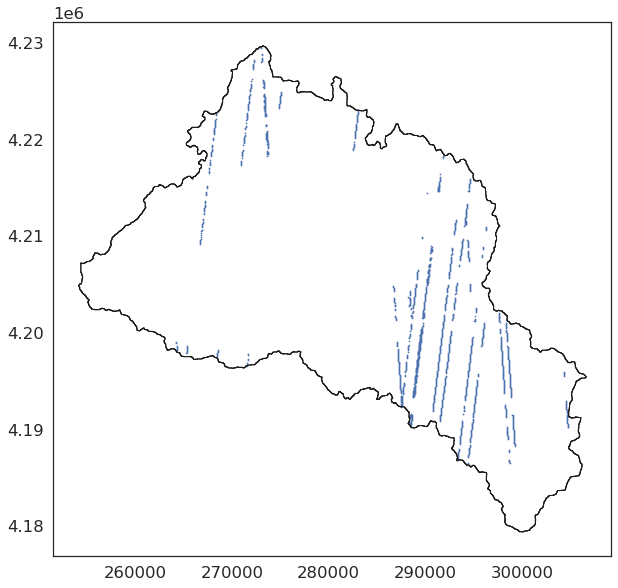

In [14]:
f, ax = plt.subplots(figsize=(10,10))
atlas_gdf_clipped.plot(ax=ax, markersize=0.5)
tuol_basin.plot(ax=ax, facecolor='none', edgecolor='k');

## Difference ASO and Low-slope ICSat-2

In [15]:
atlas_buffered = atlas_gdf_clipped.copy()
atlas_buffered['geometry'] = atlas_gdf_clipped.buffer(50)
atlas_buffered = atlas_buffered.dropna(0)

In [16]:
aso_elev = os.path.join('data',
                     'mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif')
aso_slope = os.path.join('data',
                     'ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif')

In [17]:
src = rio.open(aso_slope)
#slope_unmasked = src.read(1, masked=True)

In [18]:
#slope_unmasked

In [19]:
slope_masked, slope_ma_transform = rio.mask.mask(src, aso_gdf.geometry, nodata=(0.0))

In [20]:
slope_masked.shape

(1, 5593, 5899)

In [21]:
slope_aso = zonal_stats(atlas_buffered, slope_masked.squeeze(), affine = slope_ma_transform, geojson_out=True, nodata=(-9999.), stats='median') #geojson_out=True,

In [22]:
h_aso = zonal_stats(atlas_buffered, aso_elev, geojson_out=True, nodata=(-9999.),stats='median')

In [23]:
slope_properties = [i['properties'] for i in slope_aso if 'properties' in i]
median_slope = [i['median'] for i in slope_properties if 'median' in i]

In [24]:
atlas_final = gpd.GeoDataFrame.from_features(h_aso)
atlas_final['geometry'] = gpd.points_from_xy(atlas_gdf_clipped.x, atlas_gdf_clipped.y)
atlas_final['date'] = atlas_gdf['date']
atlas_final['slope_aso'] = median_slope
atlas_final = atlas_final.rename(columns={"median": "h_aso"})
atlas_final[atlas_final == (0.)] = np.nan
atlas_final.head()

,geometry,Track,Unnamed: 0,Unnamed: 0.1,date,dem_h,h_te_max,h_te_mean,h_te_median,h_te_min,...,h_te_uncertainty,latitude,longitude,n_te_photons,segment_snowcover,terrain_slope,x,y,h_aso,slope_aso
0,POINT (296110.079 4200924.178),gt3l,174,174.0,10/06/2020,3190.208252,3152.922852,3123.977783,3124.115479,3103.135010,...,14.805736,37.933041,-119.320015,211.0,1.0,-0.467523,296110.079162,4.200924e+06,3124.627441,NaN
1,POINT (296096.201 4200824.980),gt3l,175,175.0,10/06/2020,3133.827393,3103.147217,3087.289062,3087.147461,3074.315430,...,7.403595,37.932144,-119.320145,417.0,1.0,-0.291937,296096.201432,4.200825e+06,3087.254883,20.547213
2,POINT (296082.984 4200725.341),gt3l,176,176.0,10/06/2020,3086.844971,3074.830078,3065.325439,3064.654053,3056.949219,...,6.857558,37.931244,-119.320267,447.0,1.0,-0.178536,296082.983530,4.200725e+06,3064.038818,12.650502
3,POINT (296069.776 4200626.126),gt3l,177,177.0,10/06/2020,3065.124512,3057.640625,3049.267578,3048.199707,3046.936768,...,5.678338,37.930347,-119.320389,537.0,1.0,-0.076852,296069.775961,4.200626e+06,3048.850098,7.090505
4,POINT (296057.899 4200526.454),gt3l,178,178.0,10/06/2020,3055.509521,3047.717773,3041.521973,3040.587891,3037.197998,...,5.717147,37.929447,-119.320496,532.0,1.0,-0.099972,296057.898870,4.200526e+06,3040.695068,7.160444


In [25]:
atlas_final['difference'] = atlas_final['h_te_median'] - atlas_final['h_aso']

In [26]:
atlas_final['difference'].describe()

count    1799.000000
mean       -0.038419
std         2.301620
min       -11.489014
25%        -0.901978
50%         0.114258
75%         0.934082
max        15.370850
Name: difference, dtype: float64

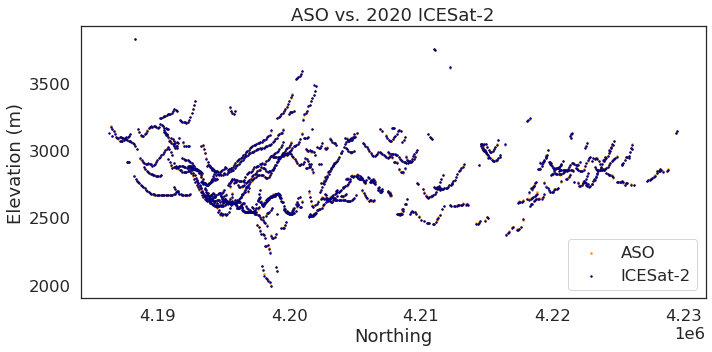

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(atlas_final['y'],atlas_final['h_aso'], c='darkorange', s=2, label = 'ASO')
ax.scatter(atlas_final['y'],atlas_final['h_te_median'], c='navy', s=2, label = 'ICESat-2')
#ax.set_ylim(1750, 3300)
ax.set_xlabel('Northing')
ax.set_ylabel('Elevation (m)')
ax.set_title('ASO vs. 2020 ICESat-2')
ax.legend(loc = 'lower right')
fig.tight_layout()
plt.savefig('2020_dif_ASO_profile.jpeg', dpi=300)
#ax.set_xlim(4.196*(10**6),4.215*(10**6))

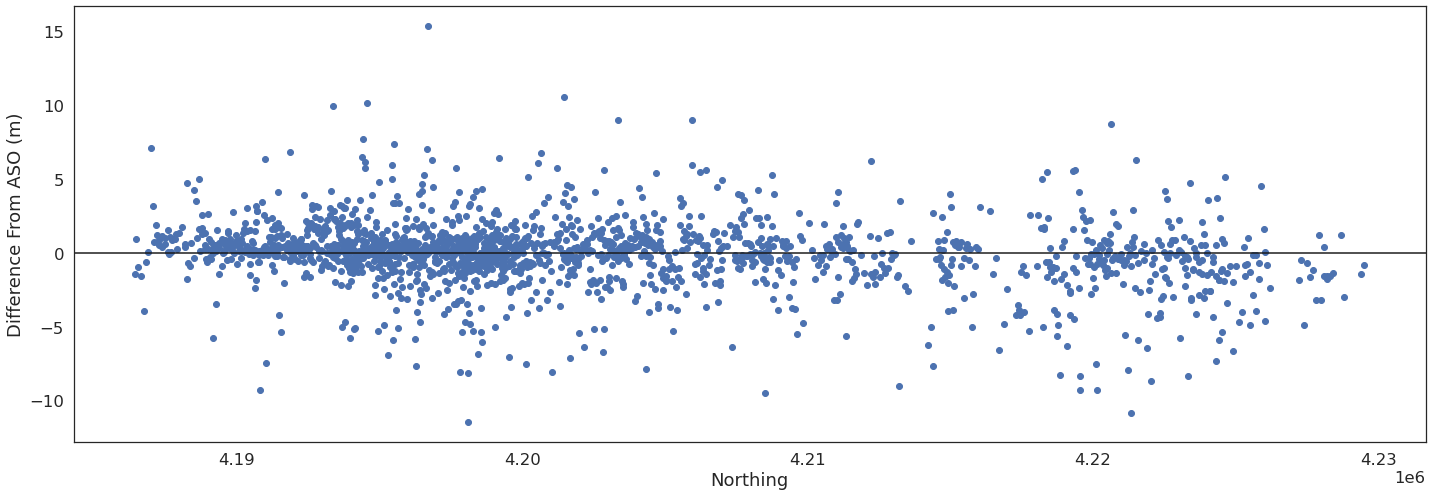

In [28]:
fig, ax = plt.subplots(figsize=(20,7))
ax.scatter(atlas_final['y'],atlas_final['difference'], cmap=atlas_final['slope_aso'])
ax.axhline(y=0, c='k')
#plt.xlim( 4.19e+06, 4.2176e+06)
#plt.ylim(-6, 3)
plt.xlabel('Northing')
plt.ylabel('Difference From ASO (m)')
plt.tight_layout()
plt.savefig('2020_Dif.jpeg', dpi=300)

In [29]:
# atlas_final[atlas_2020_final['difference'] < (-250)] = np.nan
# atlas_final[atlas_2020_final['difference'] > (250)] = np.nan

In [30]:
# Change name of output files depending on time frame you read in
winter_2020_difference = pd.DataFrame(atlas_final)
winter_2020_difference.to_csv('winter_2020_difference.csv')